In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from post_processing import *
from utils import *
# from fast_macro_f1_func import *
from sklearn.metrics import f1_score
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

In [2]:
# chris clean dataset
df_train = pd.read_csv("../input/train_clean.csv")
df_test = pd.read_csv("../input/test_clean.csv")

df_train["local_time"] = df_train.time % 50
df_train.loc[df_train.local_time == 0.0000, "local_time"] = 50

df_test["local_time"] = df_test.time % 50
df_test.loc[df_test.local_time == 0.0000, "local_time"] = 50

df_test["mini_local_time"] = df_test.time % 10
df_test.loc[df_test.local_time == 0.0000, "mini_local_time"] = 10

BATCH_SIZE = 500000

# train
for batch_i in range(10):
    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
# test
for batch_i in range(4):
    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

    df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
    df_test.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
    df_test.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
    df_test.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
    df_test.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
    
df_train = df_train.drop(df_train[(df_train.batch.isin([8]))].index)


In [3]:
# channel 0 - batch 1
channel_0_batch_1 = df_train[(df_train.batch == 1) & (df_train.open_channels == 0)]
channel_0_batch_1_threshold = channel_0_batch_1.signal.quantile(0.99999)
channel_0_batch_1.loc[channel_0_batch_1.signal > channel_0_batch_1_threshold, "signal"] = channel_0_batch_1_threshold
df_train.loc[(df_train.batch == 1) & (df_train.open_channels == 0), "signal"] = channel_0_batch_1.signal

In [4]:
df_train.loc[(df_train.batch.isin([5, 10])), "signal"] += 2.726
df_test.loc[(df_test.batch.isin([2])) & (df_test.mini_batch.isin([1, 3])),
            "signal"] += 2.726

In [5]:
# df_train = pd.read_pickle('../features/train_v2.pkl')
# df_test = pd.read_pickle('../features/test_v2.pkl')

sub = pd.read_csv("../input/sample_submission.csv")
sub['time'] = [format(sub.time.values[x], '.4f') for x in range(2000000)]
TARGET = "open_channels"

print(df_train.shape, df_test.shape, sub.shape)
df_train.head()

(4500000, 6) (2000000, 6) (2000000, 2)


,time,signal,open_channels,local_time,batch,mini_batch
0,0.0001,-2.7600,0,0.0001,1.0,1.0
1,0.0002,-2.8557,0,0.0002,1.0,1.0
2,0.0003,-2.4074,0,0.0003,1.0,1.0
3,0.0004,-3.1404,0,0.0004,1.0,1.0
4,0.0005,-3.1525,0,0.0005,1.0,1.0


In [6]:
shift = 5

def fe(df):
    
    for shift_val in range(1, shift + 1):
    
        df[f'shift+{shift_val}'] = df.groupby(['batch']).shift(shift_val)['signal']
        df[f'shift_{shift_val}'] = df.groupby(['batch']).shift(-shift_val)['signal']
        
#         df[f'diff+{shift_val}'] = df[f'shift+{shift_val}'] - df['signal']
#         df[f'diff_{shift_val}'] = df[f'shift_{shift_val}'] - df['signal']
        
#         df[f'add+{shift_val}'] = df[f'shift+{shift_val}'] + df['signal']
#         df[f'add_{shift_val}'] = df[f'shift_{shift_val}'] + df['signal']
        
#         df[f'mul+{shift_val}'] = df[f'shift+{shift_val}'] * df['signal']
#         df[f'mul_{shift_val}'] = df[f'shift_{shift_val}'] * df['signal']

    return df

def fe_test(df):
    
    for shift_val in range(1, shift + 1):
    
        df[f'shift+{shift_val}'] = df.groupby(['batch', 'mini_batch']).shift(shift_val)['signal']
        df[f'shift_{shift_val}'] = df.groupby(['batch', 'mini_batch']).shift(-shift_val)['signal']

#         df[f'diff+{shift_val}'] = df[f'shift+{shift_val}'] - df['signal']
#         df[f'diff_{shift_val}'] = df[f'shift_{shift_val}'] - df['signal']
        
#         df[f'add+{shift_val}'] = df[f'shift+{shift_val}'] + df['signal']
#         df[f'add_{shift_val}'] = df[f'shift_{shift_val}'] + df['signal']

    return df

print("feature engineering on training data ...")
df_train = fe(df_train)
print("feature engineering on testing data ...")
df_test = fe_test(df_test) # should group mini-batch ***

df_train.dropna(inplace=True)
df_test.fillna(method = "bfill", inplace=True)
df_test.fillna(method = "ffill", inplace=True)

print("feature engineering is done ...")

feature engineering on training data ...
feature engineering on testing data ...
feature engineering is done ...


In [7]:
color_list = [
    "b", "g", "r", "c", "m", "k", "y", '#0000FF', '#8A2BE2', '#A52A2A',
    '#DEB887', '#5F9EA0'
]

# drop useless features
drop_features = [
    "time",
    "open_channels",
    "local_time",
    "batch",
    "mini_batch",
    "oof",
]
all_features = [col for col in df_train.columns if col not in drop_features]
D = len(all_features)

print("train/test shape is:", df_train.shape, df_test.shape)
print("features used # is", len(all_features))
df_train[all_features].head()

train/test shape is: (4499910, 16) (2000000, 16)
features used # is 11


,signal,shift+1,shift_1,shift+2,shift_2,shift+3,shift_3,shift+4,shift_4,shift+5,shift_5
5,-2.6418,-3.1525,-2.6993,-3.1404,-2.5935,-2.4074,-2.6682,-2.8557,-2.7586,-2.7600,-3.1136
6,-2.6993,-2.6418,-2.5935,-3.1525,-2.6682,-3.1404,-2.7586,-2.4074,-3.1136,-2.8557,-2.6221
7,-2.5935,-2.6993,-2.6682,-2.6418,-2.7586,-3.1525,-3.1136,-3.1404,-2.6221,-2.4074,-2.7316
8,-2.6682,-2.5935,-2.7586,-2.6993,-3.1136,-2.6418,-2.6221,-3.1525,-2.7316,-3.1404,-2.9028
9,-2.7586,-2.6682,-3.1136,-2.5935,-2.6221,-2.6993,-2.7316,-2.6418,-2.9028,-3.1525,-2.7736


In [8]:
def get_mean_cov(x, n_components):

    gmm = GaussianMixture(n_components,
                          random_state=42,
                          max_iter=100,
                          n_init=10)
    gmm.fit(x)
    ms = gmm.means_
    ps = gmm.precisions_

    return ms, ps

### model 1 - batch 1&2

In [9]:
# model 1: batch 1&2
BATCH_GROUP_1 = [1,2]
df_train_1 = df_train[df_train.batch.isin(BATCH_GROUP_1)]

# get mean and cov
gmm_mean_1 = []
gmm_cov_1 = []

for channel_i in range(2):
    channel = df_train_1[df_train_1.open_channels == channel_i][all_features]
    ms, ps = get_mean_cov(channel, 2)
    gmm_mean_1.append(ms)
    gmm_cov_1.append(ps)
gmm_mean_1 = np.array(gmm_mean_1).reshape([-1,D])
gmm_cov_1 = np.array(gmm_cov_1).reshape([-1,D,D])

print(gmm_mean_1.shape, gmm_cov_1.shape)

(4, 11) (4, 11, 11)


In [10]:
# gmm
gmm_1 = GaussianMixture(n_components=4,
                        init_params='kmeans',
                        covariance_type='full',
                        max_iter=100,
                        n_init=10,
                        random_state=42,
                        means_init=gmm_mean_1,
                        precisions_init=gmm_cov_1)
gmm_1.fit(df_train_1[all_features])

df_train.loc[df_train.batch.isin(BATCH_GROUP_1),
             "oof"] = gmm_1.predict(df_train_1[all_features])
df_train.loc[df_train.batch.isin(BATCH_GROUP_1),
             "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_1),
                                   "oof"] // 2
print(
    "Macro F1 score is:",
    f1_score(df_train[df_train.batch.isin(BATCH_GROUP_1)].oof,
             df_train[df_train.batch.isin(BATCH_GROUP_1)].open_channels,
             average='macro').round(5))
# 0.98326

Macro F1 score is: 0.99625


In [11]:
# test batch 1-1
df_test_1_1 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 1)]
df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 1),
            "open_channels"] = gmm_1.predict(df_test_1_1[all_features]) // 2

### model 2 - batch 3&7

In [12]:
# model 2: batch 3&7
BATCH_GROUP_2 = [3,7]
df_train_2 = df_train[df_train.batch.isin(BATCH_GROUP_2)]

# get mean and cov
gmm_mean_2 = []
gmm_cov_2 = []

for channel_i in range(2):
    channel = df_train_2[df_train_2.open_channels == channel_i][all_features]
    ms, ps = get_mean_cov(channel, 2)
    gmm_mean_2.append(ms)
    gmm_cov_2.append(ps)
gmm_mean_2 = np.array(gmm_mean_2).reshape([-1,D])
gmm_cov_2 = np.array(gmm_cov_2).reshape([-1,D,D])

print(gmm_mean_2.shape, gmm_cov_2.shape)

(4, 11) (4, 11, 11)


In [13]:
# gmm
gmm_2 = GaussianMixture(n_components=4,
                        init_params='kmeans',
                        covariance_type='full',
                        max_iter=100,
                        n_init=10,
                        random_state=42,
                        means_init=gmm_mean_2,
                        precisions_init=gmm_cov_2)
gmm_2.fit(df_train_2[all_features])

df_train.loc[df_train.batch.isin(BATCH_GROUP_2),
             "oof"] = gmm_2.predict(df_train_2[all_features])
df_train.loc[df_train.batch.isin(BATCH_GROUP_2),
             "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_2),
                                   "oof"] // 2
print(
    "Macro F1 score is:",
    f1_score(df_train[df_train.batch.isin(BATCH_GROUP_2)].oof,
             df_train[df_train.batch.isin(BATCH_GROUP_2)].open_channels,
             average='macro').round(5))
# 0.9954

Macro F1 score is: 0.99608


In [14]:
# test batch 1-5
df_test_1_5 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 5)]
df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 5),
            "open_channels"] = gmm_2.predict(df_test_1_5[all_features]) // 2

### model 3 - batch 4

In [15]:
# model 3: batch 4
BATCH_GROUP_3 = [4]
df_train_3 = df_train[df_train.batch.isin(BATCH_GROUP_3)]

# get mean and cov
gmm_mean_3 = []
gmm_cov_3 = []

for channel_i in range(4):
    channel = df_train_3[df_train_3.open_channels == channel_i][all_features]
    ms, ps = get_mean_cov(channel, 4)
    gmm_mean_3.append(ms)
    gmm_cov_3.append(ps)
gmm_mean_3 = np.array(gmm_mean_3).reshape([-1, D])
gmm_cov_3 = np.array(gmm_cov_3).reshape([-1, D, D])

print(gmm_mean_3.shape, gmm_cov_3.shape)

(16, 11) (16, 11, 11)


In [16]:
# gmm
gmm_3 = GaussianMixture(n_components=16,
                        init_params='kmeans',
                        covariance_type='full',
                        max_iter=100,
                        n_init=10,
                        random_state=42,
                        means_init=gmm_mean_3,
                        precisions_init=gmm_cov_3)
gmm_3.fit(df_train_3[all_features])

df_train.loc[df_train.batch.isin(BATCH_GROUP_3),
             "oof"] = gmm_3.predict(df_train_3[all_features])
df_train.loc[df_train.batch.isin(BATCH_GROUP_3),
             "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_3),
                                   "oof"] // 4
print(
    "Macro F1 score is:",
    f1_score(df_train[df_train.batch.isin(BATCH_GROUP_3)].oof,
             df_train[df_train.batch.isin(BATCH_GROUP_3)].open_channels,
             average='macro').round(5))
# 0.98063

Macro F1 score is: 0.98307


In [17]:
# test batch 1-2
df_test_1_2 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 2)]
df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 2),
            "open_channels"] = gmm_3.predict(df_test_1_2[all_features]) // 4

# test batch 1-4
df_test_1_4 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 4)]
df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 4),
            "open_channels"] = gmm_3.predict(df_test_1_4[all_features]) // 4

# test batch 2-4
df_test_2_4 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 4)]
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 4),
            "open_channels"] = gmm_3.predict(df_test_2_4[all_features]) // 4

# test batch 2-5
df_test_2_5 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 5)]
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 5),
            "open_channels"] = gmm_3.predict(df_test_2_5[all_features]) // 4

### model 4 - batch 6&9

In [18]:
# model 4: batch 6&9
BATCH_GROUP_4 = [6,9]
df_train_4 = df_train[df_train.batch.isin(BATCH_GROUP_4)]

# get mean and cov
gmm_mean_4 = []
gmm_cov_4 = []

for channel_i in range(6):
    channel = df_train_4[df_train_4.open_channels == channel_i][all_features]
    ms, ps = get_mean_cov(channel, 6)
    gmm_mean_4.append(ms)
    gmm_cov_4.append(ps)
gmm_mean_4 = np.array(gmm_mean_4).reshape([-1, D])
gmm_cov_4 = np.array(gmm_cov_4).reshape([-1, D, D])

print(gmm_mean_4.shape, gmm_cov_4.shape)

(36, 11) (36, 11, 11)


In [19]:
# gmm
gmm_4 = GaussianMixture(n_components=36,
                        init_params='kmeans',
                        covariance_type='full',
                        max_iter=100,
                        n_init=10,
                        random_state=42,
                        means_init=gmm_mean_4,
                        precisions_init=gmm_cov_4)
gmm_4.fit(df_train_4[all_features])

df_train.loc[df_train.batch.isin(BATCH_GROUP_4),
             "oof"] = gmm_4.predict(df_train_4[all_features])
df_train.loc[df_train.batch.isin(BATCH_GROUP_4),
             "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_4),
                                   "oof"] // 6
print(
    "Macro F1 score is:",
    f1_score(df_train[df_train.batch.isin(BATCH_GROUP_4)].oof,
             df_train[df_train.batch.isin(BATCH_GROUP_4)].open_channels,
             average='macro').round(5))
# 0.96627

Macro F1 score is: 0.96716


In [20]:
# test batch 1-3
df_test_1_3 = df_test[(df_test.batch == 1) & (df_test.mini_batch == 3)]
df_test.loc[(df_test.batch == 1) & (df_test.mini_batch == 3),
            "open_channels"] = gmm_4.predict(df_test_1_3[all_features]) // 6

# test batch 2-2
df_test_2_2 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 2)]
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 2),
            "open_channels"] = gmm_4.predict(df_test_2_2[all_features]) // 6

### model 5 - batch 5&10

In [21]:
df_train = df_train.drop(df_train[(df_train.batch.isin([5, 10]))
                                  & (df_train.open_channels.isin([0]))].index)

In [22]:
# model 5: batch 5&10
BATCH_GROUP_5 = [5,10]
df_train_5 = df_train[df_train.batch.isin(BATCH_GROUP_5)]

# get mean and cov
gmm_mean_5 = []
gmm_cov_5 = []

for channel_i in range(1, 11):
    channel = df_train_5[df_train_5.open_channels == channel_i][all_features]
    ms, ps = get_mean_cov(channel, 5)
    gmm_mean_5.append(ms)
    gmm_cov_5.append(ps)
gmm_mean_5 = np.array(gmm_mean_5).reshape([-1, D])
gmm_cov_5 = np.array(gmm_cov_5).reshape([-1, D, D])

print(gmm_mean_5.shape, gmm_cov_5.shape)

(50, 11) (50, 11, 11)


In [23]:
# gmm
gmm_5 = GaussianMixture(n_components=50,
                        init_params='kmeans',
                        covariance_type='full',
                        max_iter=100,
                        n_init=10,
                        random_state=42,
                        means_init=gmm_mean_5,
                        precisions_init=gmm_cov_5)
gmm_5.fit(df_train_5[all_features])

df_train.loc[df_train.batch.isin(BATCH_GROUP_5),
             "oof"] = gmm_5.predict(df_train_5[all_features])
df_train.loc[
    df_train.batch.isin(BATCH_GROUP_5),
    "oof"] = df_train.loc[df_train.batch.isin(BATCH_GROUP_5), "oof"] // 5 + 1
print(
    "Macro F1 score is:",
    f1_score(df_train[df_train.batch.isin(BATCH_GROUP_5)].oof,
             df_train[df_train.batch.isin(BATCH_GROUP_5)].open_channels,
             average='macro').round(5))
# 0.86039

Macro F1 score is: 0.86019


In [24]:
# test batch 2-1
df_test_2_1 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 1)]
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 1),
            "open_channels"] = gmm_5.predict(df_test_2_1[all_features]) // 5 + 1

# test batch 2-3
df_test_2_3 = df_test[(df_test.batch == 2) & (df_test.mini_batch == 3)]
df_test.loc[(df_test.batch == 2) & (df_test.mini_batch == 3),
            "open_channels"] = gmm_5.predict(df_test_2_3[all_features]) // 5 + 1

In [25]:
print("=======================================================")
print("Macro F1 score is:",
      f1_score(df_train.oof, df_train.open_channels, average='macro').round(5))
# 0.93252

Macro F1 score is: 0.93377


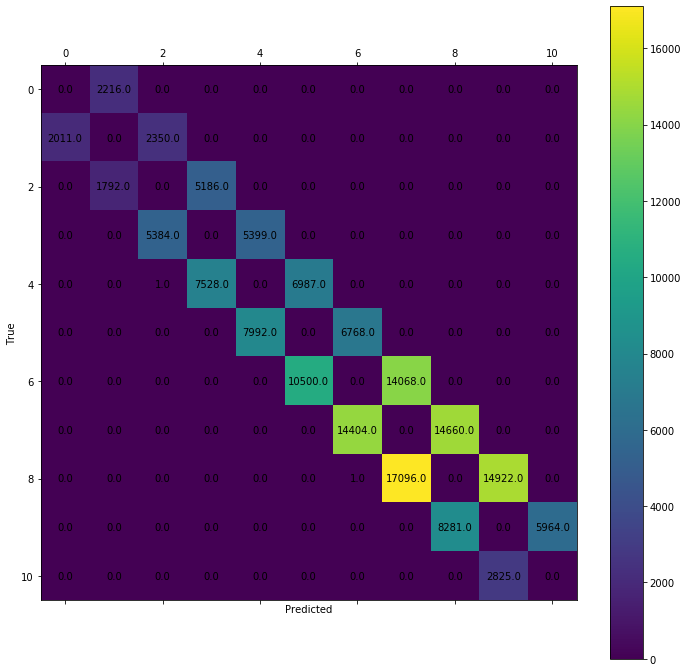

In [26]:
cm = confusion_matrix(df_train[TARGET], df_train["oof"], range(11))
cm = cm - np.eye(11) * cm
labels = range(11)
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)

for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

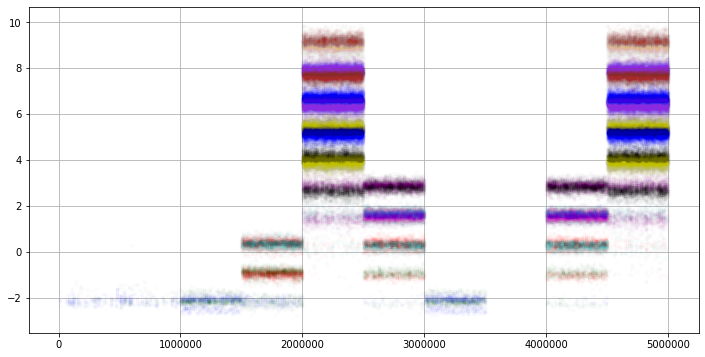

In [27]:
# oof error plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_train[df_train.open_channels == channel_i][df_train.oof != df_train.open_channels].signal, ".", color=color_list[channel_i], alpha=0.01)

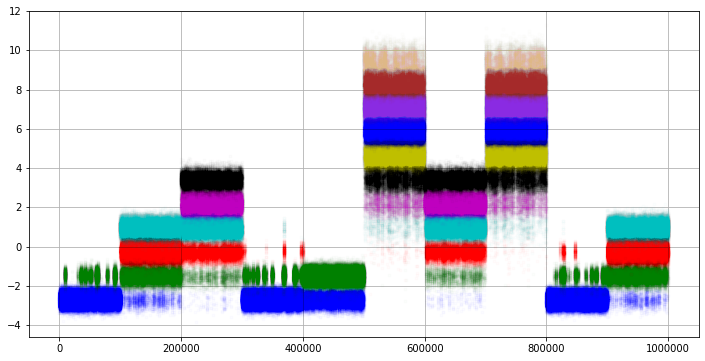

In [28]:
# test plot
fig = plt.figure(figsize=(12, 6))
plt.grid()
for channel_i in range(11):
    plt.plot(df_test[df_test.open_channels == channel_i].signal, ".", color=color_list[channel_i], alpha=0.01)

In [29]:
sub["open_channels"] = df_test.open_channels.astype("int64")
# sub.to_csv("../submissions/sub.csv", index=None)
sub.head()

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# # chris clean dataset
# df_train = pd.read_csv("../input/train_clean.csv")
# df_test = pd.read_csv("../input/test_clean.csv")

# df_train["local_time"] = df_train.time % 50
# df_train.loc[df_train.local_time == 0.0000, "local_time"] = 50

# df_test["local_time"] = df_test.time % 50
# df_test.loc[df_test.local_time == 0.0000, "local_time"] = 50

# df_test["mini_local_time"] = df_test.time % 10
# df_test.loc[df_test.local_time == 0.0000, "mini_local_time"] = 10

# BATCH_SIZE = 500000

# # train
# for batch_i in range(10):
#     df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

#     df_train.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
#     df_train.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
#     df_train.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
#     df_train.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
#     df_train.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5
# # test
# for batch_i in range(4):
#     df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 500000, 'batch'] = batch_i + 1

#     df_test.loc[BATCH_SIZE * batch_i:BATCH_SIZE * batch_i + 100000, 'mini_batch'] = 1
#     df_test.loc[BATCH_SIZE * batch_i + 100000:BATCH_SIZE * batch_i + 200000, 'mini_batch'] = 2
#     df_test.loc[BATCH_SIZE * batch_i + 200000:BATCH_SIZE * batch_i + 300000, 'mini_batch'] = 3
#     df_test.loc[BATCH_SIZE * batch_i + 300000:BATCH_SIZE * batch_i + 400000, 'mini_batch'] = 4
#     df_test.loc[BATCH_SIZE * batch_i + 400000:BATCH_SIZE * batch_i + 500000, 'mini_batch'] = 5